<a href="https://colab.research.google.com/github/Adrianus-Bagas/Klasifikasi-Jenis-Sampah/blob/main/Klasifikasi_Jenis_Sampah_(Training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Jenis Sampah

## 1. Import beberapa libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import *

## 2. Memuat data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
disease_types=['O','R']
data_dir = '/content/drive/MyDrive/dataset/sampah/'
dir = os.path.join(data_dir)

In [ ]:
data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(dir, sp)):
        data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
df = pd.DataFrame(data, columns=['File', 'Label','Jenis'])
df

,File,Label,Jenis
0,O/O_13377.jpg,0,O
1,O/O_13092.jpg,0,O
2,O/O_13284.jpg,0,O
3,O/O_12958.jpg,0,O
4,O/O_12998.jpg,0,O
...,...,...,...
2219,R/R_10411.jpg,1,R
2220,R/R_10425.jpg,1,R
2221,R/R_10872.jpg,1,R
2222,R/R_10435.jpg,1,R


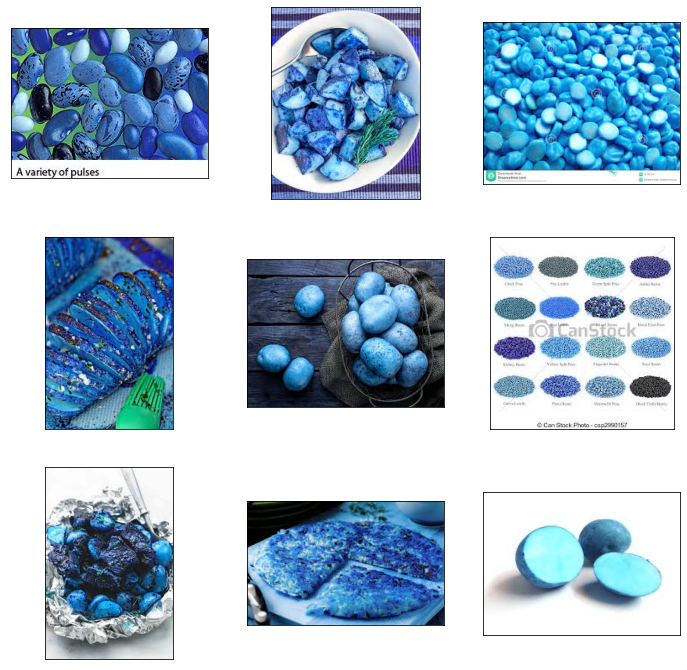

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = df['File'][df['Jenis'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('O', 3, 3)

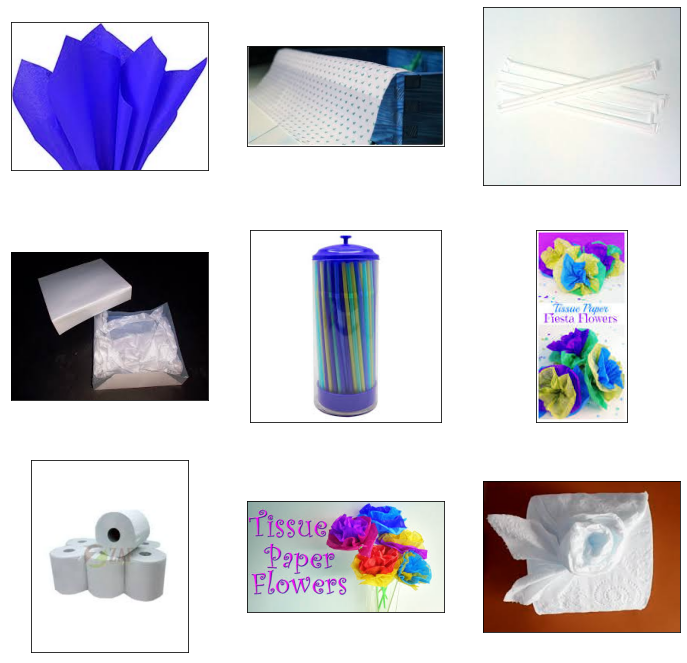

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = df['File'][df['Jenis'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('R', 3, 3)

## 3. Image Preprocessing

In [ ]:
IMAGE_SIZE = 100
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X = []
for i, file in tqdm(enumerate(df['File'].values)):
    image = read_image(file)
    if image is not None:
        # gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        resized = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
        X.append(resized)

2224it [10:36,  3.50it/s]


In [ ]:
X=np.array(X)/255.0
X=np.reshape(X,(X.shape[0],IMAGE_SIZE,IMAGE_SIZE,3))
X.shape

(2224, 100, 100, 3)

In [ ]:
Y = df['Label'].values
Y = to_categorical(Y, num_classes=2)

In [ ]:
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# 4. Model VGG

## a. VGG16

In [ ]:
model_mob = VGG16(input_shape=(100,100,3),include_top=False,weights='imagenet')
model_mob.trainable=False
model_1=Sequential()
model_1.add(model_mob)

model_1.add(Flatten())
model_1.add(Dropout(0.5))
model_1.add(Dense(64,activation='relu',kernel_regularizer='l2'))
model_1.add(Dropout(0.5))
model_1.add(Dense(32,activation='relu',kernel_regularizer='l2'))
model_1.add(Dense(2,activation='softmax'))

model_1.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model_1.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 64)                294976    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                         

In [ ]:
# Fits the model on batches with real-time data augmentation
hist = model_1.fit(X_train, Y_train, batch_size=64, epochs=5, validation_data=(X_val, Y_val))

Epoch 1/5
32/32 [==============================] - 15s 120ms/step - loss: 1.7197 - accuracy: 0.7586 - val_loss: 1.2309 - val_accuracy: 0.9058
Epoch 2/5
32/32 [==============================] - 2s 74ms/step - loss: 1.1136 - accuracy: 0.8706 - val_loss: 0.9316 - val_accuracy: 0.9193
Epoch 3/5
32/32 [==============================] - 2s 74ms/step - loss: 0.8898 - accuracy: 0.8916 - val_loss: 0.7302 - val_accuracy: 0.9327
Epoch 4/5
32/32 [==============================] - 2s 74ms/step - loss: 0.7391 - accuracy: 0.9025 - val_loss: 0.6650 - val_accuracy: 0.9417
Epoch 5/5
32/32 [==============================] - 2s 74ms/step - loss: 0.6424 - accuracy: 0.9135 - val_loss: 0.5845 - val_accuracy: 0.9372


In [ ]:
final_loss, final_accuracy = model_1.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

7/7 [==============================] - 1s 37ms/step - loss: 0.5845 - accuracy: 0.9372
Final Loss: 0.5845356583595276, Final Accuracy: 0.9372197389602661


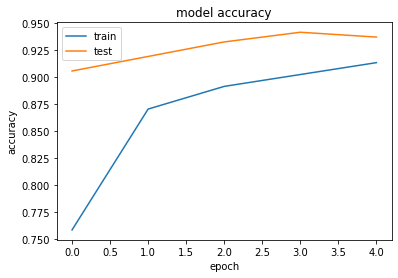

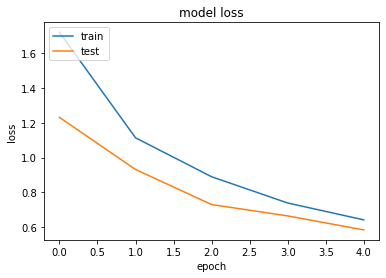

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

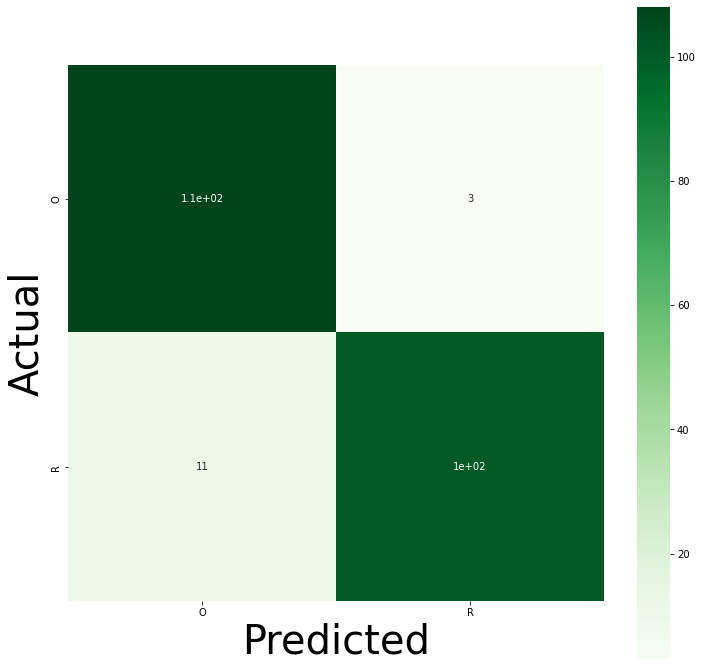

In [ ]:
Y_pred = model_1.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:
cm

array([[110,   1],
       [ 10, 102]])

## b. VGG19

In [ ]:
model_mob2 = VGG19(input_shape=(100,100,3),include_top=False,weights='imagenet')
model_mob2.trainable=False
model_2=Sequential()
model_2.add(model_mob2)

model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(64,activation='relu',kernel_regularizer='l2'))
model_2.add(Dropout(0.5))
model_2.add(Dense(32,activation='relu',kernel_regularizer='l2'))
model_2.add(Dense(2,activation='softmax'))

model_2.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model_2.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                294976    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                       

In [ ]:
# Fits the model on batches with real-time data augmentation
hist = model_2.fit(X_train, Y_train, batch_size=64, epochs=5, validation_data=(X_val, Y_val))

Epoch 1/5
32/32 [==============================] - 4s 97ms/step - loss: 1.7313 - accuracy: 0.7676 - val_loss: 1.1941 - val_accuracy: 0.9193
Epoch 2/5
32/32 [==============================] - 3s 88ms/step - loss: 1.1139 - accuracy: 0.8691 - val_loss: 0.9131 - val_accuracy: 0.9148
Epoch 3/5
32/32 [==============================] - 3s 87ms/step - loss: 0.8775 - accuracy: 0.8891 - val_loss: 0.7504 - val_accuracy: 0.9327
Epoch 4/5
32/32 [==============================] - 3s 87ms/step - loss: 0.7409 - accuracy: 0.8946 - val_loss: 0.6352 - val_accuracy: 0.9283
Epoch 5/5
32/32 [==============================] - 3s 87ms/step - loss: 0.6519 - accuracy: 0.8936 - val_loss: 0.5654 - val_accuracy: 0.9238


In [ ]:
final_loss, final_accuracy = model_2.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

7/7 [==============================] - 0s 52ms/step - loss: 0.5654 - accuracy: 0.9238
Final Loss: 0.5654177069664001, Final Accuracy: 0.9237667918205261


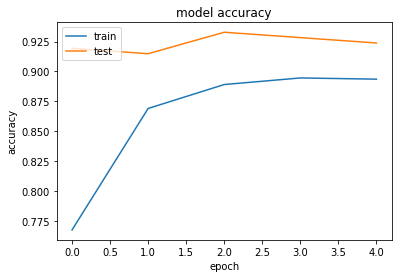

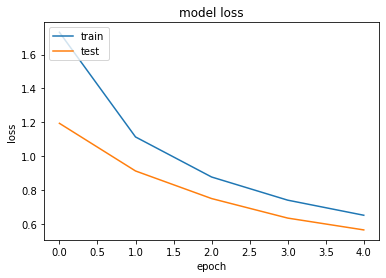

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

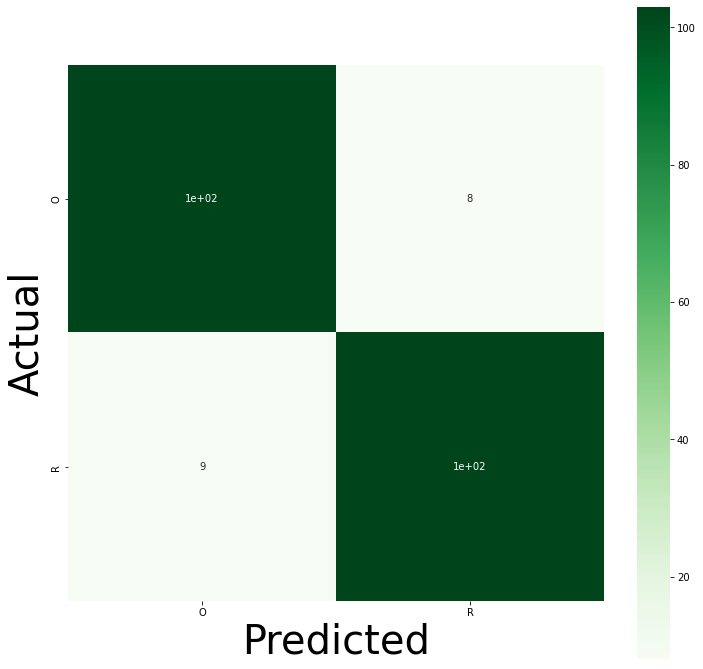

In [ ]:
Y_pred = model_2.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:
# model.save('model densenet.h5')

In [ ]:
# X_val.shape

In [ ]:
# cm = confusion_matrix(Y_true, Y_pred)
# cm

In [ ]:
# model_1.save('/content/drive/MyDrive/model/model sampah.h5')